<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Mads/AML_autoencoder_worst_bu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! gdown --id 1FkB-wMHYzgK74-pek2H33DIpmfSOIxWc  # copy this line for peru data
! unzip Insoluables_TrainingData26May2022.zip
! unzip Peru_data.zip                           # copy this line for peru data
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
from Models import make_autoencoder, make_NN
! gdown --id 1vmtn2HUFFspLehTO-9HNCnphSdiZGez3
! gdown --id 1vOWLDeQh2EEyH2J3VH5XZHhTLqMqAjkV
! gdown --id 1fv_xxclDQrccHZ-T00-cVYHIMFaYjklA
! gdown --id 1NATGxPWVYS71Y-dwPZQvrE7BdsoSpVP8
! unzip autoencoder_128.zip
! unzip encoder_128.zip
! unzip NN_scalar_encoder_128.zip
! unzip NN_last_layer_scalar_encoder_128.zip
!pip install pyyaml h5py 
!pip install umap-learn
!pip install bayesian-optimization

Streaming output truncated to the last 5000 lines.
 extracting: images/QCY/QCY_27_2_5_334.png  
 extracting: images/QCY/QCY_27_2_5_335.png  
 extracting: images/QCY/QCY_27_2_5_336.png  
 extracting: images/QCY/QCY_27_2_5_337.png  
 extracting: images/QCY/QCY_27_2_5_338.png  
 extracting: images/QCY/QCY_27_2_5_339.png  
 extracting: images/QCY/QCY_27_2_5_34.png  
 extracting: images/QCY/QCY_27_2_5_340.png  
 extracting: images/QCY/QCY_27_2_5_341.png  
  inflating: images/QCY/QCY_27_2_5_342.png  
 extracting: images/QCY/QCY_27_2_5_343.png  
 extracting: images/QCY/QCY_27_2_5_344.png  
  inflating: images/QCY/QCY_27_2_5_345.png  
 extracting: images/QCY/QCY_27_2_5_346.png  
 extracting: images/QCY/QCY_27_2_5_347.png  
  inflating: images/QCY/QCY_27_2_5_348.png  
 extracting: images/QCY/QCY_27_2_5_349.png  
 extracting: images/QCY/QCY_27_2_5_35.png  
 extracting: images/QCY/QCY_27_2_5_350.png  
 extracting: images/QCY/QCY_27_2_5_351.png  
 extracting: images/QCY/QCY_27_2_5_352.png  
 extra

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state=37)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [4]:
# copy this cell for peru data
peru_path = '/content/QCY.csv'
peru_im_path = '/content/images/QCY/'
peru_df = pd.read_csv(peru_path)
test = not_training_set(peru_df, peru_im_path, train.scaler)

In [5]:
# save image_size
im_e, _ = test.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [6]:
#train_size = len(train.labels)
test_size = len(test.imgpaths)

In [7]:
encoder = keras.models.load_model('encoder_128')
autoencoder = keras.models.load_model('autoencoder_128')

In [8]:
x_test, _ = test.__getitem__(0)
x_test = np.array([x_test])
#x_lab = np.array([x_lab])

In [9]:
autoencoder.evaluate(x_test, x_test)

1/1 [==============================] - 1s 1s/step - loss: 2.5886e-04


0.00025886340881697834

In [10]:
test_size

102764

In [11]:
test_increment = 3000
nr_tests = test_size//test_increment
#nr_trains=1
points_left_over = test_size % test_increment

mse = tf.keras.losses.MeanSquaredError()

losses = []

im_count = 0
for i in range(nr_tests):

  x_test = []
  for j in range(test_increment):
    im, _ = test.__getitem__(im_count)
    im_count += 1
    x_test.append(im)
  x_test = np.array(x_test)

  auto_preds = autoencoder.predict(x_test).reshape((test_increment,128,128))

  for j in range(test_increment):
    losses.append(mse(x_test[j], auto_preds[j]).numpy())

x_test = []
for i in range(points_left_over):
  im, _ = test.__getitem__(im_count)
  im_count += 1
  x_test.append(im)
x_test = np.array(x_test)

auto_preds = autoencoder.predict(x_test).reshape((points_left_over,128,128))

for j in range(points_left_over):
  losses.append(mse(x_test[j], auto_preds[j]).numpy())


In [12]:
losses = np.array(losses)

In [13]:
maxes = np.argpartition(losses, -20)[-20:]

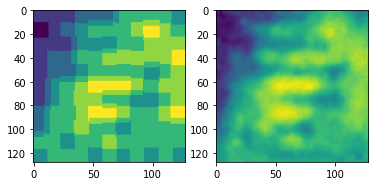

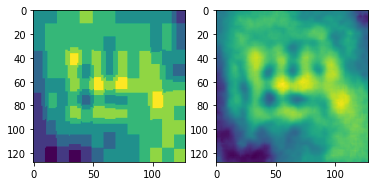

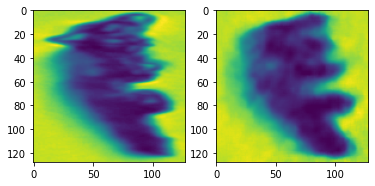

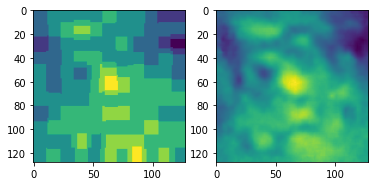

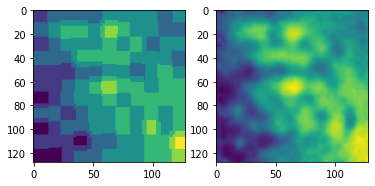

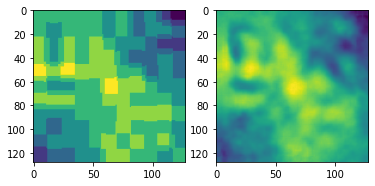

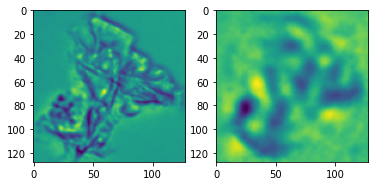

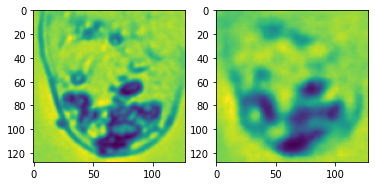

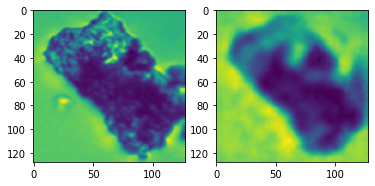

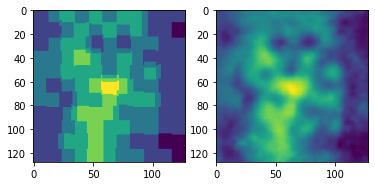

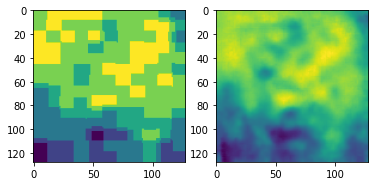

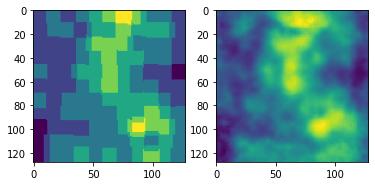

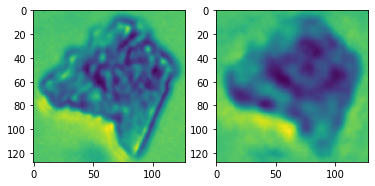

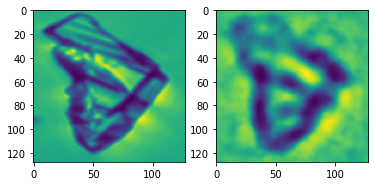

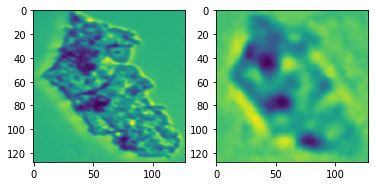

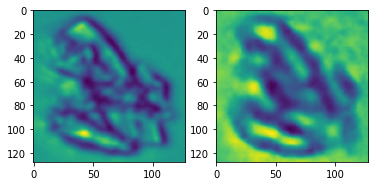

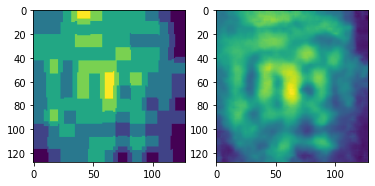

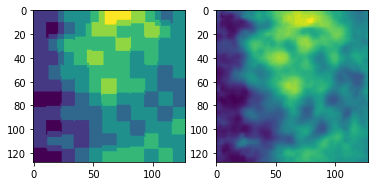

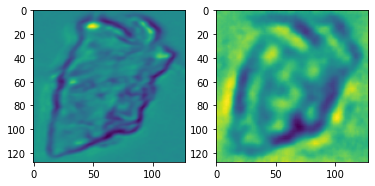

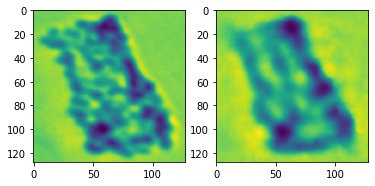

In [14]:
types = ['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub', 'cont']
for i in maxes:
  im,_ = test.__getitem__(i)
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(im)

  pred_im = autoencoder.predict(np.array([im])).reshape(128,128)
  plt.subplot(1,2,2)
  plt.imshow(pred_im)

  if i == maxes[-5]:
    plt.savefig(str(i)+'worstperu.png')
  if i == maxes[0]:
    plt.savefig(str(i)+'worstperu.png')

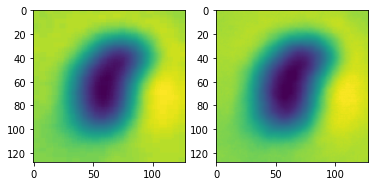

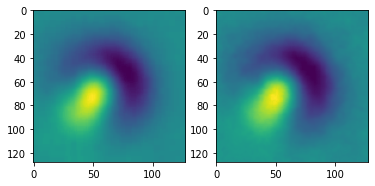

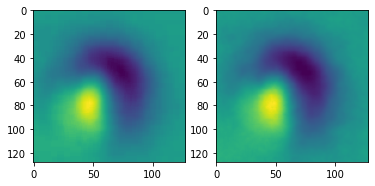

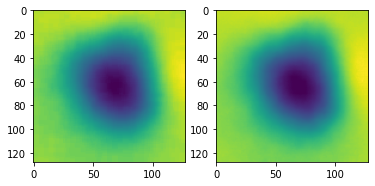

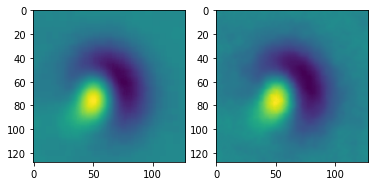

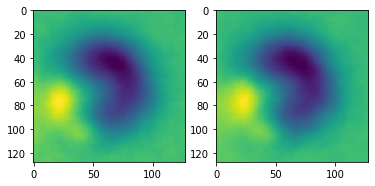

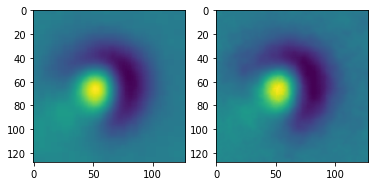

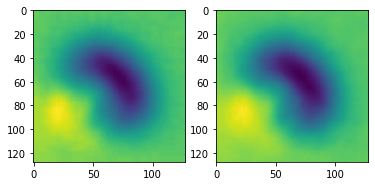

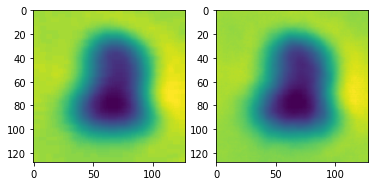

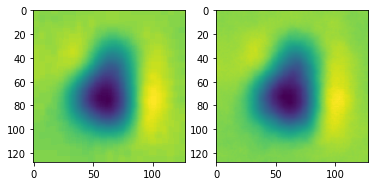

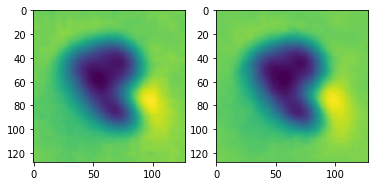

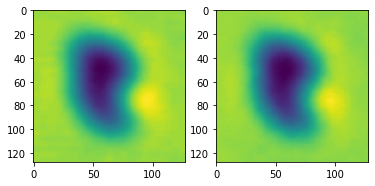

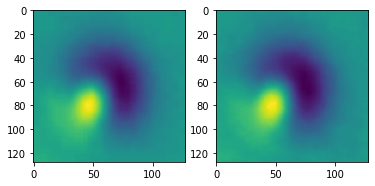

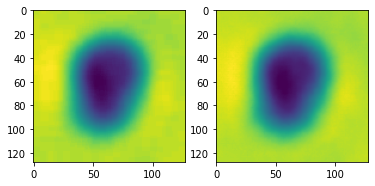

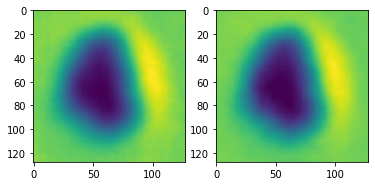

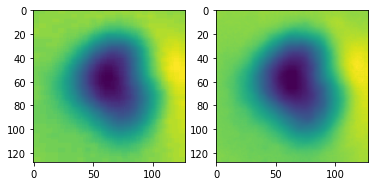

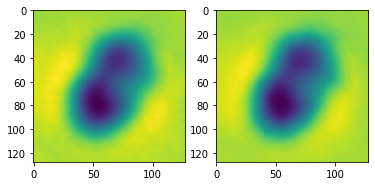

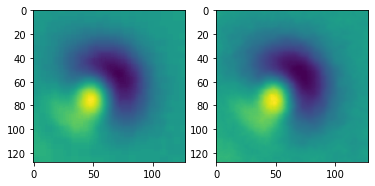

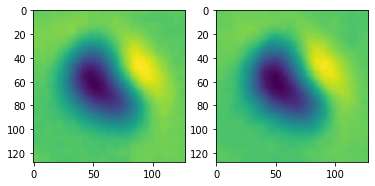

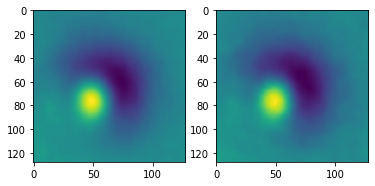

In [15]:
maxes = np.argpartition(losses, 20)[:20]
for i in maxes:
  im,_ = test.__getitem__(i)
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(im)

  pred_im = autoencoder.predict(np.array([im])).reshape(128,128)
  plt.subplot(1,2,2)
  plt.imshow(pred_im)